In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
fName = "../data/filtered-20190103-22-53-substorms.csv"
ssOnDF = pandas.read_csv(fName, parse_dates=["Date_UTC"])
# rename the cols
ssOnDF.columns = [ "datetime", "mlat", "mlt" ]
# convert to hour
ssOnDF.set_index( pandas.to_datetime(\
                        ssOnDF["datetime"]), inplace=True )
ssOnDF.head()

,datetime,mlat,mlt
datetime,,,
1996-01-01 20:16:00,1996-01-01 20:16:00,71.32,22.45
1996-01-01 23:36:00,1996-01-01 23:36:00,70.23,0.07
1996-01-02 00:25:00,1996-01-02 00:25:00,69.36,22.92
1996-01-02 14:12:00,1996-01-02 14:12:00,70.06,23.20
1996-01-02 16:09:00,1996-01-02 16:09:00,65.81,0.62


In [3]:
def pred_bin_out(row, nBins, binTimeRes):
    """
    Given the prediction label, get the actual
    output in bins by converting the label into
    binary representation. For ex, label 2 would
    convert to 10 and 5 to 101 and so on.
    """
    # Note we need the binary format to be consistent
    # with the actual labels, i.e., it depends on the 
    # number of bins. For example, 2 could be 10 or 010.
    binFormtStr = '{0:0' + str(nBins) + 'b}'
    predBinStr = binFormtStr.format(row["pred_label"])
    # Now add these into different pred bins
    for _n, _pb in enumerate(predBinStr):
        row["pbin_" + str(_n)] = int(_pb)
    if row["label"] == 0:
        if row["pred_label"] == 0:
            predType = "TN"
        else:
            predType = "FP"
    if row["label"] == 1:
        if row["pred_label"] == 1:
            predType = "TP"
        else:
            predType = "FN"
    row["pred_type"] = predType
    # Now calculate time from prev onset
    # and time to next onset
    _cpDate = row["date"]
    srchStTime = _cpDate.strftime("%Y-%m-%d %H:%M:%S")
    _nextOnsetTime = ssOnDF[ ssOnDF.index > srchStTime ].index.min()
    if not pandas.isna(_nextOnsetTime):
        _nextDelT = (_nextOnsetTime-_cpDate).total_seconds()/60.
    else:
        _nextDelT = -1
    _priorOnsetTime = ssOnDF[ ssOnDF.index < srchStTime ].index.max()
    if not pandas.isna(_priorOnsetTime):
        _priorDelT = (_cpDate-_priorOnsetTime).total_seconds()/60.
    else:
        _priorDelT = -1
    row["next_onset"] = _nextDelT
    row["prior_onset"] = _priorDelT
    # finally get the number of substorms in the bin
    srchETime = (_cpDate + datetime.timedelta(minutes=(binTimeRes+30)*nBins)\
                ).strftime("%Y-%m-%d %H:%M:%S")
    row["num_onsets"] = len( ssOnDF[ srchStTime : srchETime ].index.tolist() )
    return row

In [4]:
colNames = ["date"]
nBins = 1
binRes = 60
for _nb in range(nBins):
    colNames += [ "bin_" + str(_nb) ]
# colNames += ["label", "pred_label"]
# colNames += [ "label", "del_sml","del_sme","min_sml","max_sme","pred_label" ]
colNames += ["label", "del_minutes","pred_label"]
for _nb in range(nBins):
    # there are 2 probs for each bin
    # one zero prob and other 1 prob
    colNames += [ "prob_type_0_b_" + str(_nb) ]
    colNames += [ "prob_type_1_b_" + str(_nb) ]
print colNames
predDF = pandas.read_csv("../data/resnet_test_data_pred.csv", names=colNames,\
                     header=0, parse_dates=["date"])
predDF = predDF.apply( pred_bin_out, args=(nBins,binRes,),\
                      axis=1 )
# filter out -ve next onsets
predDF["diff_onsets"] = predDF["next_onset"] + predDF["prior_onset"]
# Also set a new term "time_from_pred_horizon" which is equal to 
# next_onset - pred_bin_time (60 min), this is equivalent
# to the time by which the prediction was missed.
predDF["time_from_pred_horizon"] = predDF["next_onset"] - binRes
predDF.head()

['date', 'bin_0', 'label', 'del_minutes', 'pred_label', 'prob_type_0_b_0', 'prob_type_1_b_0']


,date,bin_0,label,del_minutes,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,pred_type,next_onset,prior_onset,num_onsets,diff_onsets,time_from_pred_horizon
0,2015-01-27 22:50:00,1,1,29.0,1,0.316822,0.683178,1,TP,29.0,112.0,1,141.0,-31.0
1,2015-01-27 22:55:00,1,1,24.0,1,0.323714,0.676286,1,TP,24.0,117.0,1,141.0,-36.0
2,2015-01-27 23:00:00,1,1,19.0,1,0.348204,0.651796,1,TP,19.0,122.0,1,141.0,-41.0
3,2015-01-27 23:05:00,1,1,14.0,1,0.350489,0.649511,1,TP,14.0,127.0,1,141.0,-46.0
4,2015-01-27 23:10:00,1,1,9.0,1,0.329317,0.670683,1,TP,9.0,132.0,1,141.0,-51.0


In [5]:
start_date = predDF["date"].min() - datetime.timedelta(hours=2)
end_date = predDF["date"].max()
print start_date, end_date
omn_dbdir = "../data/sqlite3/"
omn_db_name = "smu_sml_sme.sqlite"
omn_table_name = "smusmlsme"

2015-01-27 20:50:00 2017-12-31 23:55:00


In [6]:
# read omni data
conn = sqlite3.connect(omn_dbdir + omn_db_name,
                       detect_types = sqlite3.PARSE_DECLTYPES)
# load data to a dataframe
command = "SELECT datetime, al, ae, au FROM {tb} WHERE datetime BETWEEN '{stm}' and '{etm}'"
command = command.format(tb=omn_table_name,\
                         stm=start_date, etm=end_date)
smlDF = pandas.read_sql(command, conn)
# drop nan's
smlDF.dropna(inplace=True)
smlDF.set_index(smlDF["datetime"], inplace=True)
smlDF.head()

,datetime,al,ae,au
datetime,,,,
2015-01-27 20:50:00,2015-01-27 20:50:00,-250,433,183
2015-01-27 20:51:00,2015-01-27 20:51:00,-248,430,182
2015-01-27 20:52:00,2015-01-27 20:52:00,-253,439,186
2015-01-27 20:53:00,2015-01-27 20:53:00,-258,443,185
2015-01-27 20:54:00,2015-01-27 20:54:00,-262,452,190


In [7]:
def get_sml_vars(row):
    """
    Get mean, median, std, min and max of sml 
    during various substorms over the next interval range.
    """
    delTimeList = [30, 60]#[ 15, 30, 60, 120 ]
    for _dtl in delTimeList:
        _pd = row["date"] - datetime.timedelta(minutes=10)
        _cd = row["date"] + datetime.timedelta(minutes=1)
        _ed = row["date"] + datetime.timedelta(minutes=_dtl)
        _resDF = smlDF[ _cd : _ed ]
        _baselineAl = smlDF[ _pd : _cd ]["al"].median()
        _baselineAe = smlDF[ _pd : _cd ]["ae"].median()
        row["mean_al_" + str(_dtl)] = _resDF["al"].mean()
        row["median_al_" + str(_dtl)] = _resDF["al"].median()
        row["min_al_" + str(_dtl)] = _resDF["al"].min()
        row["max_al_" + str(_dtl)] = _resDF["al"].max()
        # difference between current AL and minimum in the next bin
        # note this is defined to be negative, for easy binning etc
        row["al_dip" + str(_dtl)] = _resDF["al"].min() - _baselineAl
        row["ae_dip" + str(_dtl)] = _resDF["ae"].max() - _baselineAe
    return row

predDF = predDF.apply( get_sml_vars, axis=1 )
predDF.head()

,date,bin_0,label,del_minutes,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,pred_type,next_onset,...,min_al_30,max_al_30,al_dip30,ae_dip30,mean_al_60,median_al_60,min_al_60,max_al_60,al_dip60,ae_dip60
0,2015-01-27 22:50:00,1,1,29.0,1,0.316822,0.683178,1,TP,29.0,...,-146.0,-44.0,-10.0,-42.5,-131.433333,-124.0,-215.0,-44.0,-79.0,-42.5
1,2015-01-27 22:55:00,1,1,24.0,1,0.323714,0.676286,1,TP,24.0,...,-191.0,-44.0,-84.0,2.5,-141.216667,-154.0,-248.0,-44.0,-141.0,9.5
2,2015-01-27 23:00:00,1,1,19.0,1,0.348204,0.651796,1,TP,19.0,...,-191.0,-44.0,-87.5,23.0,-155.783333,-174.5,-301.0,-44.0,-197.5,80.0
3,2015-01-27 23:05:00,1,1,14.0,1,0.350489,0.649511,1,TP,14.0,...,-199.0,-44.0,-105.0,32.0,-172.100000,-187.0,-306.0,-44.0,-212.0,103.0
4,2015-01-27 23:10:00,1,1,9.0,1,0.329317,0.670683,1,TP,9.0,...,-215.0,-44.0,-128.0,45.0,-191.600000,-193.5,-314.0,-44.0,-227.0,123.0


In [8]:
# # Bin by AL
# alBins = range(-1000,100,100)
# # get the min al in the next 30 min
# oldColNames = predDF.columns.tolist()
# predDF = pandas.concat( [ predDF, \
#                     pandas.cut( predDF["min_al_30"], \
#                                bins=alBins ) ], axis=1 )
# predDF.columns = oldColNames + ["min_al_30_bin"]
# # get the min al in the next 60 min
# oldColNames = predDF.columns.tolist()
# predDF = pandas.concat( [ predDF, \
#                     pandas.cut( predDF["min_al_60"], \
#                                bins=alBins ) ], axis=1 )
# predDF.columns = oldColNames + ["min_al_60_bin"]
# # get the AL in the next 30 min
# oldColNames = predDF.columns.tolist()
# predDF = pandas.concat( [ predDF, \
#                     pandas.cut( predDF["al_dip30"], \
#                                bins=alBins ) ], axis=1 )
# predDF.columns = oldColNames + ["al_dip30_bin"]
# # get the AL in the next 60 min
# oldColNames = predDF.columns.tolist()
# predDF = pandas.concat( [ predDF, \
#                     pandas.cut( predDF["al_dip60"], \
#                                bins=alBins ) ], axis=1 )
# predDF.columns = oldColNames + ["al_dip60_bin"]

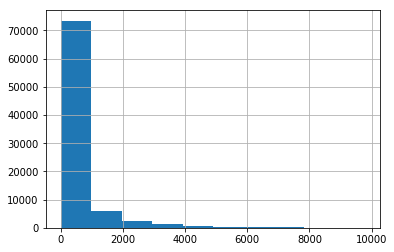

In [9]:
predDF["next_onset"].hist()

In [10]:
# next_onset and time_from_pred_horizon bins
timeBinsnOnset = range(0,2000,10)#range(0,2000,20)
# # create next_onset bins
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["next_onset"], \
                               bins=timeBinsnOnset ) ], axis=1 )
predDF.columns = oldColNames + ["next_onset_bin"]
# # create prior_onset bins
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["prior_onset"], \
                               bins=timeBinsnOnset ) ], axis=1 )
predDF.columns = oldColNames + ["prior_onset_bin"]
# create time_from_pred_horizon bins
timeBinsHorizon = range(-65,2000,10)
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["time_from_pred_horizon"], \
                               bins=timeBinsHorizon ) ], axis=1 )
predDF.columns = oldColNames + ["time_from_pred_horizon_bin"]

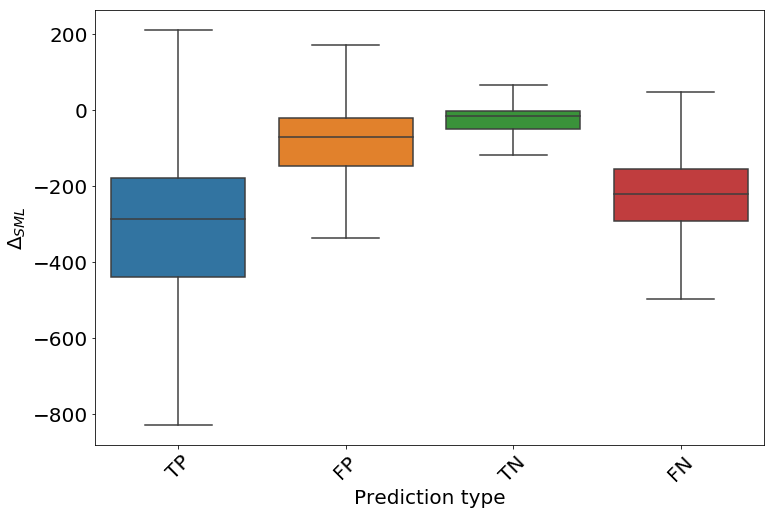

In [11]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
sns.boxplot( x="pred_type", y="al_dip60",\
            data=predDF, showfliers=False, ax=ax1 )
ax1.set_ylabel(r'$\Delta_{SML}$', fontsize=20)
ax1.set_xlabel("Prediction type", fontsize=20)
plt.xticks(rotation=45, size=20)
plt.yticks(size=20)

f.savefig("../plots/categorical_del_sml.pdf", bbox_inches='tight')

In [12]:
# tpDF = predDF[predDF["pred_type"] == "TP"]
# f = plt.figure(figsize=(12, 8))
# ax1 = f.add_subplot(2,1,1)
# sns.boxplot( x="next_onset_bin", y="prob_type_1_b_0",\
#             data=tpDF, ax=ax1 )
# ax1.set_xlim(0,12)
# fpDF = predDF[predDF["pred_type"] == "FP"]
# ax2 = f.add_subplot(2,1,2)
# sns.boxplot( x="next_onset_bin", y="prob_type_1_b_0",\
#             data=fpDF, ax=ax2 )
# ax2.set_xlim(11,80)
# plt.xticks(rotation=75)

In [13]:
tpDFMean = predDF[predDF["pred_type"] == "TP"][\
        ["next_onset_bin", "prob_type_1_b_0"]\
        ].groupby(["next_onset_bin"]).median().reset_index()
tpDFMean.columns = ["next_onset_bin", "mean_prob_type_1_b_0"]
tpDFStd = predDF[predDF["pred_type"] == "TP"][\
        ["next_onset_bin", "prob_type_1_b_0"]\
        ].groupby(["next_onset_bin"]).std().reset_index()
tpDFStd.columns = ["next_onset_bin", "std_prob_type_1_b_0"]
tpDFMean = pandas.merge( tpDFMean, tpDFStd, on=["next_onset_bin"] )
fpDFMean = predDF[predDF["pred_type"] == "FP"][\
        ["next_onset_bin", "prob_type_1_b_0"]\
        ].groupby(["next_onset_bin"]).median().reset_index()
fpDFMean.columns = ["next_onset_bin", "mean_prob_type_1_b_0"]
fpDFStd = predDF[predDF["pred_type"] == "FP"][\
        ["next_onset_bin", "prob_type_1_b_0"]\
        ].groupby(["next_onset_bin"]).std().reset_index()
fpDFStd.columns = ["next_onset_bin", "std_prob_type_1_b_0"]
fpDFMean = pandas.merge( fpDFMean, fpDFStd, on=["next_onset_bin"] )


tnDFMean = predDF[predDF["pred_type"] == "TN"][\
        ["next_onset_bin", "prob_type_0_b_0"]\
        ].groupby(["next_onset_bin"]).median().reset_index()
tnDFMean.columns = ["next_onset_bin", "mean_prob_type_0_b_0"]
tnDFStd = predDF[predDF["pred_type"] == "TN"][\
        ["next_onset_bin", "prob_type_0_b_0"]\
        ].groupby(["next_onset_bin"]).std().reset_index()
tnDFStd.columns = ["next_onset_bin", "std_prob_type_0_b_0"]
tnDFMean = pandas.merge( tnDFMean, tnDFStd, on=["next_onset_bin"] )
fnDFMean = predDF[predDF["pred_type"] == "FN"][\
        ["next_onset_bin", "prob_type_0_b_0"]\
        ].groupby(["next_onset_bin"]).median().reset_index()
fnDFMean.columns = ["next_onset_bin", "mean_prob_type_0_b_0"]
fnDFStd = predDF[predDF["pred_type"] == "FN"][\
        ["next_onset_bin", "prob_type_0_b_0"]\
        ].groupby(["next_onset_bin"]).std().reset_index()
fnDFStd.columns = ["next_onset_bin", "std_prob_type_0_b_0"]
fnDFMean = pandas.merge( fnDFMean, fnDFStd, on=["next_onset_bin"] )

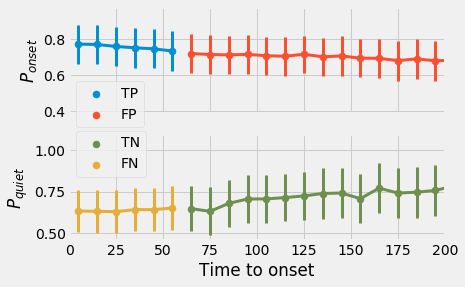

In [14]:
plt.style.use("fivethirtyeight")
f, axArr = plt.subplots(2, sharex=True)
# axArr[0] = f.add_subplot(2,1,1)
# axArr[1] = f.add_subplot(2,1,2)
# TP and FP cases
xVals = [c.mid  for c in tpDFMean["next_onset_bin"].values.categories]
axArr[0].scatter(xVals, tpDFMean['mean_prob_type_1_b_0'], s=50, label="TP")
axArr[0].errorbar( xVals, tpDFMean['mean_prob_type_1_b_0'],\
             yerr=tpDFMean['std_prob_type_1_b_0'], linewidth=3, label=None )

axArr[0].scatter(xVals, fpDFMean['mean_prob_type_1_b_0'], s=50, label="FP")
axArr[0].errorbar( xVals, fpDFMean['mean_prob_type_1_b_0'],\
             yerr=fpDFMean['std_prob_type_1_b_0'], linewidth=3, label=None )
# set the legends
axArr[0].legend(loc=3, bbox_to_anchor=(0.0, -0.2))
# axArr[0].set_ylim([0.6,0.9])
# TN and FN cases
xVals = [c.mid  for c in tnDFMean["next_onset_bin"].values.categories]
axArr[1].scatter(xVals, tnDFMean['mean_prob_type_0_b_0'], s=50,\
                 label="TN", color="#6d904f")
axArr[1].errorbar( xVals, tnDFMean['mean_prob_type_0_b_0'],\
             yerr=tnDFMean['std_prob_type_0_b_0'],\
                linewidth=3, label=None, color="#6d904f" )

axArr[1].scatter(xVals, fnDFMean['mean_prob_type_0_b_0'], s=50,\
                 label="FN", color="#e5ae38")
axArr[1].errorbar( xVals, fnDFMean['mean_prob_type_0_b_0'],\
             yerr=fnDFMean['std_prob_type_0_b_0'],\
            linewidth=3, label=None, color="#e5ae38" )
# set the legends
axArr[1].legend(loc=2, bbox_to_anchor=(0.0, 1.1))# set the axes
axArr[0].set_xlim([0,200])
axArr[1].set_xlim([0,200])
# set the titles
axArr[1].set_xlabel("Time to onset")
axArr[0].set_ylabel(r'$P_{onset}$')
axArr[1].set_ylabel(r'$P_{quiet}$')
f.savefig("../plots/categorical_time_to_onset.pdf", bbox_inches='tight')
f.savefig("../plots/categorical_time_to_onset.eps", bbox_inches='tight')

In [15]:
tpDFPOMean = predDF[predDF["pred_type"] == "TP"][\
        ["prior_onset_bin", "prob_type_1_b_0"]\
        ].groupby(["prior_onset_bin"]).median().reset_index()
tpDFPOMean.columns = ["prior_onset_bin", "mean_prob_type_1_b_0"]
tpDFPOStd = predDF[predDF["pred_type"] == "TP"][\
        ["prior_onset_bin", "prob_type_1_b_0"]\
        ].groupby(["prior_onset_bin"]).std().reset_index()
tpDFPOStd.columns = ["prior_onset_bin", "std_prob_type_1_b_0"]
tpDFPOMean = pandas.merge( tpDFPOMean, tpDFPOStd, on=["prior_onset_bin"] )
fpDFPOMean = predDF[predDF["pred_type"] == "FP"][\
        ["prior_onset_bin", "prob_type_1_b_0"]\
        ].groupby(["prior_onset_bin"]).median().reset_index()
fpDFPOMean.columns = ["prior_onset_bin", "mean_prob_type_1_b_0"]
fpDFPOStd = predDF[predDF["pred_type"] == "FP"][\
        ["prior_onset_bin", "prob_type_1_b_0"]\
        ].groupby(["prior_onset_bin"]).std().reset_index()
fpDFPOStd.columns = ["prior_onset_bin", "std_prob_type_1_b_0"]
fpDFPOMean = pandas.merge( fpDFPOMean, fpDFPOStd, on=["prior_onset_bin"] )


tnDFPOMean = predDF[predDF["pred_type"] == "TN"][\
        ["prior_onset_bin", "prob_type_0_b_0"]\
        ].groupby(["prior_onset_bin"]).median().reset_index()
tnDFPOMean.columns = ["prior_onset_bin", "mean_prob_type_0_b_0"]
tnDFPOStd = predDF[predDF["pred_type"] == "TN"][\
        ["prior_onset_bin", "prob_type_0_b_0"]\
        ].groupby(["prior_onset_bin"]).std().reset_index()
tnDFPOStd.columns = ["prior_onset_bin", "std_prob_type_0_b_0"]
tnDFPOMean = pandas.merge( tnDFPOMean, tnDFPOStd, on=["prior_onset_bin"] )
fnDFPOMean = predDF[predDF["pred_type"] == "FN"][\
        ["prior_onset_bin", "prob_type_0_b_0"]\
        ].groupby(["prior_onset_bin"]).median().reset_index()
fnDFPOMean.columns = ["prior_onset_bin", "mean_prob_type_0_b_0"]
fnDFPOStd = predDF[predDF["pred_type"] == "FN"][\
        ["prior_onset_bin", "prob_type_0_b_0"]\
        ].groupby(["prior_onset_bin"]).std().reset_index()
fnDFPOStd.columns = ["prior_onset_bin", "std_prob_type_0_b_0"]
fnDFPOMean = pandas.merge( fnDFPOMean, fnDFPOStd, on=["prior_onset_bin"] )

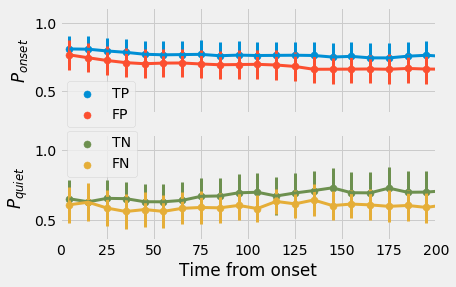

In [16]:
plt.style.use("fivethirtyeight")
f, axArr = plt.subplots(2, sharex=True)
# axArr[0] = f.add_subplot(2,1,1)
# axArr[1] = f.add_subplot(2,1,2)
# TP and FP cases
xVals = [c.mid  for c in tpDFPOMean["prior_onset_bin"].values.categories]
axArr[0].scatter(xVals, tpDFPOMean['mean_prob_type_1_b_0'], s=50, label="TP")
axArr[0].errorbar( xVals, tpDFPOMean['mean_prob_type_1_b_0'],\
             yerr=tpDFPOMean['std_prob_type_1_b_0'], linewidth=3, label=None )

axArr[0].scatter(xVals, fpDFPOMean['mean_prob_type_1_b_0'], s=50, label="FP")
axArr[0].errorbar( xVals, fpDFPOMean['mean_prob_type_1_b_0'],\
             yerr=fpDFPOMean['std_prob_type_1_b_0'], linewidth=3, label=None )
# set the legends
axArr[0].legend(loc=3, bbox_to_anchor=(0.0, -0.2))
# axArr[0].set_ylim([0.6,0.9])
# TN and FN cases
xVals = [c.mid  for c in tnDFPOMean["prior_onset_bin"].values.categories]
axArr[1].scatter(xVals, tnDFPOMean['mean_prob_type_0_b_0'], s=50,\
                 label="TN", color="#6d904f")
axArr[1].errorbar( xVals, tnDFPOMean['mean_prob_type_0_b_0'],\
             yerr=tnDFPOMean['std_prob_type_0_b_0'],\
                linewidth=3, label=None, color="#6d904f" )

axArr[1].scatter(xVals, fnDFPOMean['mean_prob_type_0_b_0'], s=50,\
                 label="FN", color="#e5ae38")
axArr[1].errorbar( xVals, fnDFPOMean['mean_prob_type_0_b_0'],\
             yerr=fnDFPOMean['std_prob_type_0_b_0'],\
            linewidth=3, label=None, color="#e5ae38" )
# set the legends
axArr[1].legend(loc=2, bbox_to_anchor=(0.0, 1.1))# set the axes
axArr[0].set_xlim([0,200])
axArr[1].set_xlim([0,200])
# set the titles
axArr[1].set_xlabel("Time from onset")
axArr[0].set_ylabel(r'$P_{onset}$')
axArr[1].set_ylabel(r'$P_{quiet}$')
f.savefig("../plots/categorical_time_from_onset.pdf", bbox_inches='tight')
f.savefig("../plots/categorical_time_from_onset.eps", bbox_inches='tight')

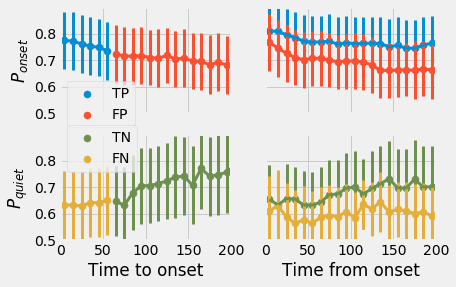

In [17]:
f, axArr = plt.subplots(2, 2, sharex='col', sharey='row')
### Time to Onset
# TP and FP cases
xVals = [c.mid  for c in tpDFMean["next_onset_bin"].values.categories]
axArr[0,0].scatter(xVals, tpDFMean['mean_prob_type_1_b_0'], s=50, label="TP")
axArr[0,0].errorbar( xVals, tpDFMean['mean_prob_type_1_b_0'],\
             yerr=tpDFMean['std_prob_type_1_b_0'], linewidth=3, label=None )

axArr[0,0].scatter(xVals, fpDFMean['mean_prob_type_1_b_0'], s=50, label="FP")
axArr[0,0].errorbar( xVals, fpDFMean['mean_prob_type_1_b_0'],\
             yerr=fpDFMean['std_prob_type_1_b_0'], linewidth=3, label=None )

# axArr[0,0].set_ylim([0.6,0.9])
# TN and FN cases
xVals = [c.mid  for c in tnDFMean["next_onset_bin"].values.categories]
axArr[1,0].scatter(xVals, tnDFMean['mean_prob_type_0_b_0'], s=50,\
                 label="TN", color="#6d904f")
axArr[1,0].errorbar( xVals, tnDFMean['mean_prob_type_0_b_0'],\
             yerr=tnDFMean['std_prob_type_0_b_0'],\
                linewidth=3, label=None, color="#6d904f" )

axArr[1,0].scatter(xVals, fnDFMean['mean_prob_type_0_b_0'], s=50,\
                 label="FN", color="#e5ae38")
axArr[1,0].errorbar( xVals, fnDFMean['mean_prob_type_0_b_0'],\
             yerr=fnDFMean['std_prob_type_0_b_0'],\
            linewidth=3, label=None, color="#e5ae38" )


### Time from Onset
# TP and FP cases
xVals = [c.mid  for c in tpDFPOMean["prior_onset_bin"].values.categories]
axArr[0,1].scatter(xVals, tpDFPOMean['mean_prob_type_1_b_0'], s=50, label="TP")
axArr[0,1].errorbar( xVals, tpDFPOMean['mean_prob_type_1_b_0'],\
             yerr=tpDFPOMean['std_prob_type_1_b_0'], linewidth=3, label=None )

axArr[0,1].scatter(xVals, fpDFPOMean['mean_prob_type_1_b_0'], s=50, label="FP")
axArr[0,1].errorbar( xVals, fpDFPOMean['mean_prob_type_1_b_0'],\
             yerr=fpDFPOMean['std_prob_type_1_b_0'], linewidth=3, label=None )
# TN and FN cases
xVals = [c.mid  for c in tnDFPOMean["prior_onset_bin"].values.categories]
axArr[1,1].scatter(xVals, tnDFPOMean['mean_prob_type_0_b_0'], s=50,\
                 label="TN", color="#6d904f")
axArr[1,1].errorbar( xVals, tnDFPOMean['mean_prob_type_0_b_0'],\
             yerr=tnDFPOMean['std_prob_type_0_b_0'],\
                linewidth=3, label=None, color="#6d904f" )

axArr[1,1].scatter(xVals, fnDFPOMean['mean_prob_type_0_b_0'], s=50,\
                 label="FN", color="#e5ae38")
axArr[1,1].errorbar( xVals, fnDFPOMean['mean_prob_type_0_b_0'],\
             yerr=fnDFPOMean['std_prob_type_0_b_0'],\
            linewidth=3, label=None, color="#e5ae38" )


# set the legends
axArr[0,0].legend(loc=3, bbox_to_anchor=(0.0, -0.2))
axArr[1,0].legend(loc=2, bbox_to_anchor=(0.0, 1.15))# set the axes
# set xlim
ylim = [0.5,0.9]
for _ax in axArr.flatten():
    _ax.set_xlim([0,200])
    _ax.set_ylim(ylim)
    _ax.set_yticks(numpy.arange(ylim[0], ylim[1], 0.1))
# set the titles
axArr[1,0].set_xlabel("Time to onset")
axArr[1,1].set_xlabel("Time from onset")
axArr[0,0].set_ylabel(r'$P_{onset}$')
axArr[1,0].set_ylabel(r'$P_{quiet}$')
# set the legends
# axArr[1,1].legend(loc=2, bbox_to_anchor=(0.0, 1.1))# set the axes


f.savefig("../plots/categorical_delT_onset.pdf", bbox_inches='tight')
f.savefig("../plots/categorical_delT_onset.eps", bbox_inches='tight')

In [18]:
# Bin by AL
alBins = range(-1000,100,100)
# get the min al in the next 30 min
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["min_al_30"], \
                               bins=alBins ) ], axis=1 )
predDF.columns = oldColNames + ["min_al_30_bin"]
# get the min al in the next 60 min
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["min_al_60"], \
                               bins=alBins ) ], axis=1 )
predDF.columns = oldColNames + ["min_al_60_bin"]
# get the AL in the next 30 min
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["al_dip30"], \
                               bins=alBins ) ], axis=1 )
predDF.columns = oldColNames + ["al_dip30_bin"]
# get the AL in the next 60 min
oldColNames = predDF.columns.tolist()
predDF = pandas.concat( [ predDF, \
                    pandas.cut( predDF["al_dip60"], \
                               bins=alBins ) ], axis=1 )
predDF.columns = oldColNames + ["al_dip60_bin"]
predDF.dropna(inplace=True)

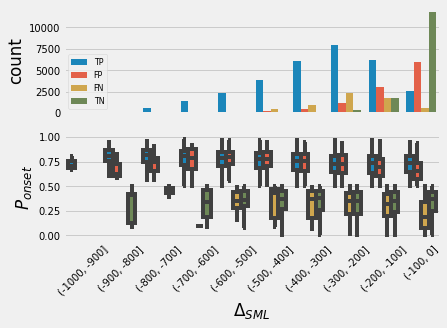

In [19]:
# from matplotlib.ticker import LogLocator

plt.style.use("fivethirtyeight")
f, axArr = plt.subplots(2, sharex=True)
sns.countplot(x="al_dip60_bin", hue="pred_type",\
              data=predDF, ax=axArr[0],\
              hue_order=["TP", "FP", "FN", "TN"])
sns.boxplot( x="al_dip60_bin", y="prob_type_1_b_0",\
             hue="pred_type", data=predDF,\
            showfliers=False, ax=axArr[1] )
# log y-scale
# axArr[0].set_yscale("log")
# xlabels
axArr[1].set_xlabel(r'$\Delta_{SML}$')
axArr[0].set_xlabel("")
#ylabels
axArr[1].set_ylabel(r'$P_{onset}$')
# legends
axArr[0].legend(loc=3, prop={'size': 8})
axArr[1].legend().set_visible(False)
# ticks
axArr[0].tick_params(axis='both', which='major', labelsize=10)
axArr[1].tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)



f.savefig("../plots/categorical_sml_dip_hist.pdf", bbox_inches='tight')
f.savefig("../plots/categorical_sml_dip_hist.eps", bbox_inches='tight')